# V1 major features:
1. Reconstruction with data, 1st and 2nd order derivatives
2. Masks in both time and frequency domian
3. Approximate the erroneous traces with approximated 1st derivatives

In [1]:
import numpy as np
import m8r
from scipy.ndimage import gaussian_filter
from scipy import signal
import pylops
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
from pylops.optimization.sparsity import *
plt.close('all')

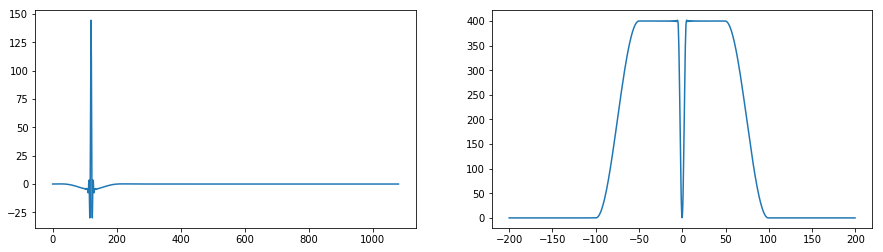

In [2]:
# load the data
wav = m8r.Input('wav_flat.rsf')
vel = m8r.Input('vel.rsf')
mat = m8r.Input('dat_full151.rsf')
w1 = wav.int("n1")
n1 = mat.int("n1")
n2 = mat.int("n2")
v1 = vel.int("n1")
v2 = vel.int("n2")
D =mat.read(shape=(n2,n1))
V = vel.read(shape=(v2,v1))
W = wav.read(shape=(w1,))
D_sqz = D.flatten()
nt,nr = D.shape
N = nt*nr

# model parameters
nx_mod = 1601
nz_mod = 801
dx_mod = 2.5
dx = 10
dz_mod = 2.5
nt_mod = 6001
dt_mod = 0.0005
dt = 0.0025

F = pylops.signalprocessing.FFT2D(dims=(nt,nr),nffts=(nt,nr))
fre = F*D.flatten()
fre = fre.reshape(nt, nr,order='C') # undo the scailing
fre_shift = np.fft.fftshift(fre)

t_min, t_max = np.amin(D[0:800,:]), np.amax(D[0:800,:])

ts = np.arange(0,nt*5,5)
W_sample = W[ts]
W_sample_fre = np.fft.fftshift(np.fft.fft(W_sample))

vn = 1/(2*0.0025)
dv = 2*vn/nt
vs = np.arange(-vn,vn,dv)

fig, axs = plt.subplots(1, 2, figsize=(15, 4))
axs[0].plot(W_sample)
axs[1].plot(vs,abs(W_sample_fre))
plt.show()



In [3]:
# calculate the nyquist wavenumber of the source
# wavenumber <= omega/(c*sin Eta)
vel_ocean = 1490

slope = dx/(vel_ocean*dt)

kn_source = 100/(vel_ocean)
dx_ny_source = 1/(2*kn_source)
print(dx_ny_source)
print(dx)

7.45
10


In [4]:
# interval = 6
# node = np.arange(0,nr,interval) 
# jitter = np.random.randint(interval,size=node.size-1)
# jitter_last = np.random.randint(nr - node[-1])
# jitter = np.concatenate((jitter,jitter_last),axis=None)
# idr = node + jitter
# print(idr)

idr = np.load('int6_idr.npy')
cod = np.arange(0,nt*nr).reshape(nt,nr)
idx = cod[:,idr].flatten()

receiver = np.arange(nr)
idd = np.delete(receiver,idr)
iddx = cod[:,idd].flatten()
R_d = pylops.Restriction(N, iddx)
D1_dec_p = R_d*np.zeros((nt,nr)).flatten()
# print(idd)

R = pylops.Restriction(N, idx)
D_dec = (R*D_sqz).reshape(nt,idr.size)
D_adj = (R.H*D_dec.flatten()).reshape(nt,nr)


Text(0.5, 1.0, 'k-f domain (with mask in time)')

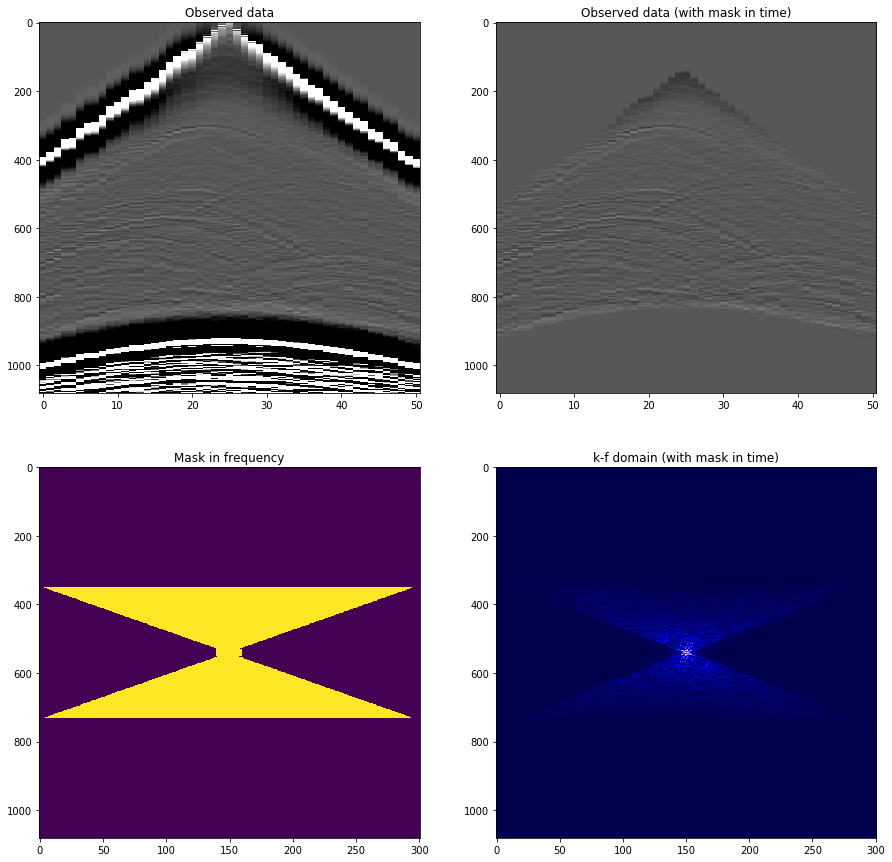

In [5]:
# mask for direct waves
vel_ocean = 1490

x1 = np.arange(150)
x2 = np.arange(150,301)
t1 = (150-x1)*dx/(vel_ocean*dt)
t2 = (x2-150)*dx/(vel_ocean*dt) 
t_vec = np.concatenate((t1,t2),axis=None) + 140

# mask for sediment reflection
t3 = np.sqrt(830**2 + ((150-x1)*dx)**2/((vel_ocean*dt)**2))
t4 = np.sqrt(830**2 + ((x2-150)*dx)**2/((vel_ocean*dt)**2))
t_vec2 = np.concatenate((t3,t4),axis=None)

mask_t2 = np.zeros((nt,nr))
for i in np.arange(nr):
    mask_t2[int(t_vec[i]):int(t_vec2[i]),i] = 1

Sop_t = pylops.Smoothing2D(nsmooth=[11,3], dims=[nt, nr])

mask_2 = pylops.Diagonal(Sop_t*mask_t2.flatten())
D_adj_mask = (mask_2*D_adj.flatten()).reshape(nt,nr)
D_dec_mask = (R*D_adj_mask.flatten()).reshape(nt,idr.size)

D_mask2 = mask_2*D.flatten()
D_aft = D_mask2.reshape(nt,nr)
D_aft_fre = np.fft.fftshift((np.fft.fft2(D_aft)))

##################
#mask on frequency
##################
kn=1/(2*dx)
dk=2*kn/nr

mask_fre_loc = np.zeros((nt,nr))
vel = 1450

v = np.zeros(nt)
k1 = np.zeros(nt)
k2 = np.zeros(nt)
for i in np.arange(350,540):
#     v[i] = -vn + i*dv
    k1[i] = ((-vn + i*dv)/(vel)) /dk +150
    k2[i] = ((-vn + i*dv)/(-1*vel)) /dk +150
    mask_fre_loc[i,int(k1[i]):int(k2[i])] = 1
for i in np.arange(540,730):
    k1[i] = ((-vn + i*dv)/(vel) ) /dk +150
    k2[i] = ((-vn + i*dv)/(-1*vel) ) /dk +150
    mask_fre_loc[i,int(k2[i]):int(k1[i])] = 1

mask_fre_loc[530:550,140:160] = 1
mask_fre_iff = np.fft.ifftshift(mask_fre_loc.reshape(nt,nr))
mask_fre = pylops.Diagonal(mask_fre_iff)
fre_dec = np.fft.fftshift(np.fft.fft2(D_dec_mask))

fig, axs = plt.subplots(2, 2, figsize=(15, 15))
axs[0,0].imshow(D_dec,cmap='gray',aspect='auto',vmin=t_min/10,vmax=t_max/10)
axs[0,0].set_title('Observed data')
axs[0,1].imshow(D_dec_mask,cmap='gray',aspect='auto',vmin=t_min/10,vmax=t_max/10)
axs[0,1].set_title('Observed data (with mask in time)')
axs[1,0].imshow(mask_fre_loc,aspect='auto')
axs[1,0].set_title('Mask in frequency')
axs[1,1].imshow(abs(D_aft_fre),aspect='auto',cmap='seismic')
axs[1,1].set_title('k-f domain (with mask in time)')

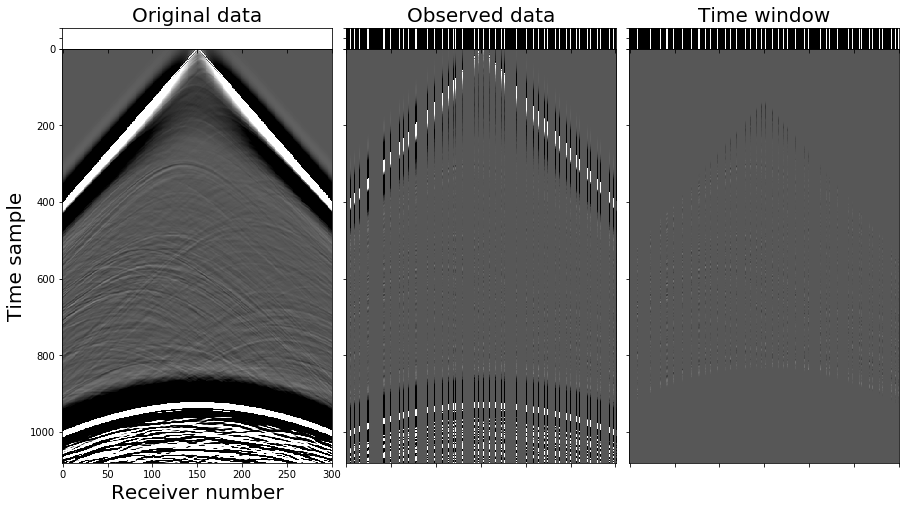

In [22]:
array_1 = np.ones((1,nr))
array_2 = np.zeros((1,nr))

array_2[:,idr] = 1

fig = plt.figure(figsize = (15,8))
gs = gridspec.GridSpec(2, 3,height_ratios=[0.05,1])
gs.update(wspace=0.05, hspace=0.00)
ax1 = plt.subplot(gs[3])
ax2 = plt.subplot(gs[4])
ax3 = plt.subplot(gs[5])

ax4 = plt.subplot(gs[0])
ax5 = plt.subplot(gs[1])
ax6 = plt.subplot(gs[2])

ax1.imshow(D.reshape(nt,nr,order='C'),cmap='gray',aspect='auto',vmin=t_min/10,vmax=t_max/10)
ax1.set_title('Original data',y=1.05,fontsize=20)
ax1.set_xlabel('Receiver number', fontsize=20)
ax1.set_ylabel('Time sample', fontsize=20)
ax2.imshow(D_adj.reshape(nt,nr,order='C'),cmap='gray',aspect='auto',vmin=t_min/10,vmax=t_max/10)
ax2.set_title('Observed data',y=1.05,fontsize=20)
ax2.set_xticklabels([])
ax2.set_yticklabels([])
ax3.imshow(D_adj_mask.reshape(nt,nr,order='C'),cmap='gray',aspect='auto',vmin=t_min/10,vmax=t_max/10)
ax3.set_title('Time window',y=1.05,fontsize=20)
ax3.set_xticklabels([])
ax3.set_yticklabels([])

ax4.imshow(array_1,cmap='gray',aspect='auto',vmin=0,vmax=1)
ax4.set_xticklabels([])
ax4.set_yticklabels([])

ax5.imshow(array_2,cmap='gray',aspect='auto',vmin=0,vmax=1)
ax5.set_xticklabels([])
ax5.set_yticklabels([])

ax6.imshow(array_2,cmap='gray',aspect='auto',vmin=0,vmax=1)
ax6.set_xticklabels([])
ax6.set_yticklabels([])

fig.savefig('tur_sample.eps', format='eps', dpi=100,bbox_inches='tight')

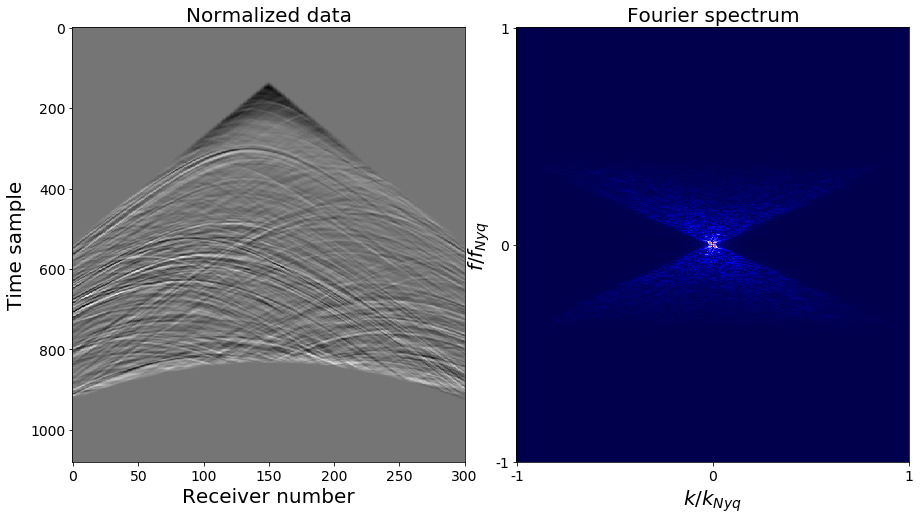

In [7]:
scail = abs((D_aft).max())
ND = (D_aft)/ scail

fig = plt.figure(figsize = (15,8))
gs = gridspec.GridSpec(1, 2)
gs.update(wspace=0.13, hspace=0.25)
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
# ax3 = plt.subplot(gs[2])

xaxis = np.array([-1,0,1])
yaxis = np.array([-1,0,1])

xticks = np.array([0,int(nr-1)/2,int(nr-1)])
yticks = np.array([0,int(nt-1)/2,int(nt-1)])

ax1.imshow(ND.reshape(nt,nr,order='C'),cmap='gray',aspect='auto')
ax1.set_title('Normalized data',fontsize=20)
ax1.set_xlabel('Receiver number', fontsize=20)
ax1.set_ylabel('Time sample', fontsize=20)
ax1.tick_params(axis = 'both', which = 'major', labelsize = 14)
ax2.imshow(abs(D_aft_fre),aspect='auto',cmap='seismic')
ax2.set_title('Fourier spectrum',fontsize=20)
ax2.set_xlabel(r'$k/k_{Nyq}$', fontsize=20)
ax2.set_ylabel(r'$f/f_{Nyq}$', fontsize=20)
ax2.set_xticks(xticks)
ax2.set_xticklabels(xaxis)
ax2.set_yticks(yticks)
ax2.set_yticklabels(np.flip(yaxis))
ax2.tick_params(axis = 'both', which = 'major', labelsize = 14)

# fig.savefig('ND.eps', format='eps', dpi=100,bbox_inches='tight')

In [ ]:
# calculate derivatives from original data(with masks and highpass)
fre_sqz = F*ND.flatten() # change it if scailing is used

dx=10
kn=1/(2*dx)
ks = np.fft.fftfreq(nr, d=dx)

dt=0.0025
fn=1/(2*dt);

coeff1 = 1j*2*np.pi*ks
coeff2 = -(2*np.pi*ks)**2

coeff1_m = np.tile(coeff1,nt)
coeff2_m = np.tile(coeff2,nt)

D1op_hand = pylops.Diagonal(coeff1_m)
D2op_hand = pylops.Diagonal(coeff2_m)

D1_hand_fre = D1op_hand*fre_sqz
D2_hand_fre = D2op_hand*fre_sqz

D1_hand = F.H*D1_hand_fre
D2_hand = F.H*D2_hand_fre


In [ ]:
# solve the linear equations
D2_dec = np.real(R*(D2_hand))
D1_dec = np.real(R*(D1_hand))
D_dec = R*ND.flatten()

Forward = pylops.VStack([R, R*F.H*D1op_hand*F, R*F.H*D2op_hand*F])
rhs = np.concatenate((D_dec, D1_dec, D2_dec), axis=0)

Forward2 = pylops.VStack([R*mask_2*F.H*mask_fre, 
                          R*mask_2*F.H*D1op_hand*mask_fre, 
                          R*mask_2*F.H*D2op_hand*mask_fre
                          ])
rhs2 = np.concatenate((D_dec, D1_dec, D2_dec), axis=0)



In [ ]:
####################
### LSQR solver ####
####################
xinv_ = \
    pylops.optimization.leastsquares.RegularizedInversion(Forward2, [], rhs2, 
                                                          **dict(damp=0, iter_lim=600, show=0))

# xinv2 = \
#     pylops.optimization.leastsquares.RegularizedInversion(Forward2, [], rhs2, 
#                                                           **dict(damp=0, iter_lim=800, show=1))
#####################
### SPGL1 solver ###
####################
# xinv, pspgl, info = SPGL1(Forward, rhs,returninfo=True, 
#                              **dict(iterations=50))

sigma = np.linalg.norm(rhs2 - (Forward2*xinv_))

xinv2_, pspgl2, info2 = SPGL1(Forward2, rhs2,sigma=sigma,returninfo=True, 
                             **dict(iterations=10))

sigma2 = np.linalg.norm(rhs2 - (Forward2*xinv2_))

In [ ]:
# print(sigma)
# print(sigma2)
# print(info2)

In [ ]:
xinv = scail*mask_2*F.H*mask_fre*xinv_
xinv2 = scail*mask_2*F.H*mask_fre*xinv2_

xinv = np.real(xinv.reshape(nt,nr,order='C'))
xinv2 = np.real(xinv2.reshape(nt,nr,order='C'))

xinv_fre = np.fft.fftshift(np.fft.fft2(xinv))
xinv2_fre = np.fft.fftshift(np.fft.fft2(xinv2))
fre_ref = D_aft_fre.reshape(nt,nr)

relative = np.abs((xinv - D_aft) / np.amax(D_aft))
relative2 = np.abs((xinv2 - D_aft) / np.amax(D_aft))

relative_fre = np.abs((xinv_fre - fre_ref) / np.amax(fre_ref))
relative2_fre = np.abs((xinv2_fre - fre_ref) / np.amax(fre_ref))

In [ ]:
combined_data = np.array([relative,relative2])
t_min, t_max = np.amin(combined_data), np.amax(combined_data)

combined_data = np.array([relative_fre,relative2_fre])
f_min, f_max = np.amin(combined_data), np.amax(combined_data)

fig, axs = plt.subplots(4, 2, figsize=(15, 30))
axs[0,0].imshow(np.real(xinv),cmap='gray',aspect='auto')
axs[0,0].set_title('LSQR')
axs[0,1].imshow(np.real(xinv2),cmap='gray',aspect='auto')
axs[0,1].set_title('SPGL1')
im1 = axs[1,0].imshow(relative,cmap='gray',aspect='auto',vmin=t_min, vmax =t_max)
im2 = axs[1,1].imshow(relative2,cmap='gray',aspect='auto',vmin=t_min, vmax =t_max)
fig.colorbar(im1,ax=axs[1,0])
fig.colorbar(im2,ax=axs[1,1])
axs[1,0].set_title('Relative error')
axs[1,1].set_title('Relative error')
axs[2,0].imshow(np.abs(xinv_fre),cmap='seismic',aspect='auto')
axs[2,1].imshow(np.abs(xinv2_fre),cmap='seismic',aspect='auto')
im3 = axs[3,0].imshow(relative_fre,cmap='seismic',aspect='auto',vmin=f_min, vmax =f_max)
im4 = axs[3,1].imshow(relative2_fre,cmap='seismic',aspect='auto',vmin=f_min, vmax =f_max)
axs[3,0].set_title('Relative error')
axs[3,1].set_title('Relative error')
fig.colorbar(im3,ax=axs[3,0])
fig.colorbar(im4,ax=axs[3,1])

In [ ]:
fig = plt.figure(figsize = (22,8))
gs = gridspec.GridSpec(1, 3)
gs.update(wspace=0.25, hspace=0.25)
ax1 = plt.subplot(gs[0])
ax2 = plt.subplot(gs[1])
ax3 = plt.subplot(gs[2])

xaxis = np.array([-1,0,1])
yaxis = np.array([-1,0,1])

xticks = np.array([0,int(nr-1)/2,int(nr-1)])
yticks = np.array([0,int(nt-1)/2,int(nt-1)])

ax1.imshow(np.real(xinv),cmap='gray',aspect='auto')
ax1.set_title('Reconstruction',fontsize=20)
ax1.set_xlabel('Receiver number', fontsize=20)
ax1.set_ylabel('Time sample', fontsize=20)
ax1.tick_params(axis = 'both', which = 'major', labelsize = 14)

im1 = ax2.imshow(relative,aspect='auto',cmap='gray')
ax2.set_title('Relative error',fontsize=20)
ax2.set_xlabel('Receiver number', fontsize=20)
ax2.set_ylabel('Time sample', fontsize=20)

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", "5%", pad="3%")
cbar = plt.colorbar(im1, cax=cax)
cbar.ax.tick_params(labelsize=12) 

im2 = ax3.imshow(relative_fre,aspect='auto',cmap='seismic')
ax3.set_title('Relative error in Fourier spectrum',fontsize=20)
ax3.set_xlabel(r'$k/k_{Nyq}$', fontsize=20)
ax3.set_ylabel(r'$f/f_{Nyq}$', fontsize=20)
ax3.set_xticks(xticks)
ax3.set_xticklabels(xaxis)
ax3.set_yticks(yticks)
ax3.set_yticklabels(np.flip(yaxis))
ax3.tick_params(axis = 'both', which = 'major', labelsize = 14)

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax3)
cax = divider.append_axes("right", "5%", pad="3%")
cbar = plt.colorbar(im2, cax=cax)
cbar.ax.tick_params(labelsize=12) 

fig.savefig('tur_re.eps', format='eps', dpi=100,bbox_inches='tight')

# Re-improvement:
1. choose the traces with high relative error
2. set the 1st derivative of these traces by calculating from surrounding fine-reconstructed traces.
3. Build up another linear system to solve the new xinv

In [ ]:
error_trace = relative.sum(axis=0)
loc_etrace = np.where(error_trace>0.5*error_trace.max())
sample = np.ones((nt,nr))
sample[:,loc_etrace[0]] = 0

receiver = np.arange(nr)
cod = np.arange(0,nt*nr).reshape(nt,nr)
idde = cod[:,loc_etrace[0]]
idds = cod[:,np.delete(receiver,loc_etrace[0])]

R_error = pylops.Restriction(N, idde.flatten())
R_sample = pylops.Restriction(N, idds.flatten())

errors = np.zeros((nt,nr)) # for demonstration purpose 
errors[:,loc_etrace[0]] = 1

d1op_fd = pylops.FirstDerivative(N,dims=(nt, nr), dir=1)
d1_re = (d1op_fd * np.real(D_aft).flatten()).reshape(nt,nr)

fig, axs = plt.subplots(1,2,figsize=(15, 8))
im1 = axs[0].imshow(errors,cmap='gray',aspect='auto')
im2 = axs[1].imshow(d1_re,cmap='gray',aspect='auto')
plt.colorbar(im2,ax=axs[1])
plt.show()

In [ ]:
# calculate 
traces = R_sample * np.real(xinv).flatten()
traces_adj = (R_sample.H*traces).reshape(nt,nr)

# y[i] = (0.5x[i+1] - 0.5x[i-1]) / dx
x = traces_adj.copy()
y = np.zeros((nt,nr))

receiver = np.arange(nr)
er = np.delete(receiver,loc_etrace[0]) # calculating the gap for errorneous traces
ds = er[1:] - er[0:-1]

colum = er.copy()
mark1 = np.where(ds>1)
mark_re = mark1[0]

for i in np.arange(mark_re.size):
    a,b = int(mark_re[i]),int(mark_re[i]+1)
    vec = (0.5*xinv[:,er[b]]-0.5*xinv[:,er[a]])/(ds[a]*dx)
    y[:,er[a]:er[b]]=(np.tile(vec.reshape(nt,1),(1,ds[a])))

sumt = y.sum(axis=0)
locd1 = np.where(sumt>0)
cod = np.arange(0,nt*nr).reshape(nt,nr)
R_d_re = pylops.Restriction(N,(cod[:,locd1]).flatten())


fig, axs = plt.subplots(1,2,figsize=(15, 8))
axs[0].imshow(traces_adj,cmap='gray',aspect='auto')
axs[1].imshow(y,cmap='gray',aspect='auto')

In [ ]:
D_dec_re = R_sample * np.real(xinv).flatten()
D1_dec_re = R_error * y.flatten()


In [ ]:
Forward_re2 = pylops.VStack([R_sample*mask_2*F.H*mask_fre, 
                          R_error*mask_2*F.H*D1op_hand*mask_fre, 
                          ])
rhs_re2 = np.concatenate((D_dec_re, D1_dec_re), axis=0)

xinv_re2 = \
    pylops.optimization.leastsquares.RegularizedInversion(Forward_re2, [], rhs_re2, 
                                                          **dict(damp=0, iter_lim=600, show=0))
xinv_re2 = mask_2*F.H*mask_fre*xinv_re2

In [ ]:
relative3 = np.abs((xinv_re2.reshape(nt,nr) - D_aft)) / np.amax(abs(D_aft))
relative4 = np.abs((xinv - D_aft)) / np.amax(abs(D_aft))

fig, axs = plt.subplots(2,2,figsize=(15, 16))
im3 = axs[0,0].imshow(np.real(xinv_re2).reshape(nt,nr),cmap='gray',aspect='auto')
im4 = axs[0,1].imshow(np.real(xinv),cmap='gray',aspect='auto')
im1 = axs[1,0].imshow(relative3,cmap='gray',aspect='auto',vmin=t_min, vmax =t_max)
im2 = axs[1,1].imshow(relative4,cmap='gray',aspect='auto',vmin=t_min, vmax =t_max)
fig.colorbar(im1,ax=axs[1,0])
fig.colorbar(im2,ax=axs[1,1])
plt.show()